In [ ]:
# Install p7zip
!apt-get install p7zip-full

# Extract the archive using 7zip
!7z x /content/archive.zip -o/content/dataset


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 63252113 bytes (61 MiB)

Extracting archive: /content/archive.zip
 11% 4096 Open              --
Path = /content/archive.zip
Type = zip
Physical Size = 63252113

  0%    
Would you like to replace the existing file:
  Path:     /content/dataset/test/angry/PrivateTest_10131363.jpg
  Size:     1722 bytes (2 KiB)
  Modified: 2020-07-19 12:25:48
with the file from archive:
  Path:     test/angry/PrivateTest_10131363.jpg
  Size:    

In [ ]:
!ls /content/dataset/train
!ls /content/dataset/test

angry  disgust	fear  happy  neutral  sad  surprise
angry  disgust	fear  happy  neutral  sad  surprise


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator from the correct location
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, MaxPooling2D # Remove CuDNNLSTM
from keras.models import Sequential
from keras import regularizers
import keras

from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import cv2
# %%


In [ ]:

train_dir = '/content/dataset/train'
val_dir = '/content/dataset/test'

In [ ]:
image_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=2,
    vertical_flip=2
)

training_set = image_generator.flow_from_directory(batch_size=256,
                                                 directory=train_dir,
                                                 shuffle=True,
                                                 target_size=(48, 48),
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                )

testing_set = image_generator.flow_from_directory(batch_size=128,
                                                 directory=val_dir,
                                                 shuffle=True,
                                                 target_size=(48, 48),
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                 )


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [16]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        train_dir,
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        val_dir,
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [17]:
dim = (48,48) # for MobileNetV2
n_sequence = 8 # for LSTM
n_channels = 3 # color channel(RGB)
n_output = 7 #18 # number of output class

In [19]:
model = Sequential()
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add(
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False),
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
from tensorflow.keras.layers import LSTM # Import LSTM from tensorflow.keras.layers
model.add(LSTM(64, return_sequences=False)) # Use LSTM instead of CuDNNLSTM
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(24, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(n_output, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-19-e49fa0810c4b>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNetV2(weights='imagenet',include_top=False),
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

model.compile(optimizer = "adam",loss = "categorical_crossentropy" , metrics=['accuracy'])
# Replace fit_generator with fit, which now accepts generators directly
hist = model.fit(training_set, validation_data = testing_set , epochs = 5)

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 222ms/step - accuracy: 0.3332 - loss: 1.6878 - val_accuracy: 0.2884 - val_loss: 2.5094
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 202ms/step - accuracy: 0.4267 - loss: 1.5068 - val_accuracy: 0.3493 - val_loss: 2.0294
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.4668 - loss: 1.4303 - val_accuracy: 0.3833 - val_loss: 1.8062
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.4857 - loss: 1.3805 - val_accuracy: 0.2774 - val_loss: 1.7593
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 204ms/step - accuracy: 0.4959 - loss: 1.3597 - val_accuracy: 0.3426 - val_loss: 2.3850


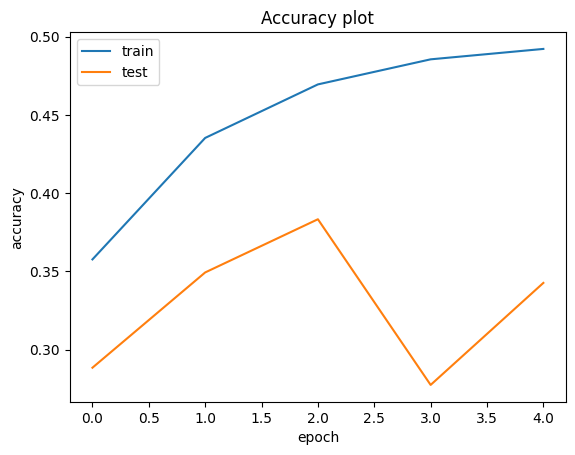

In [23]:
hist = hist.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv3_accuracy.png")

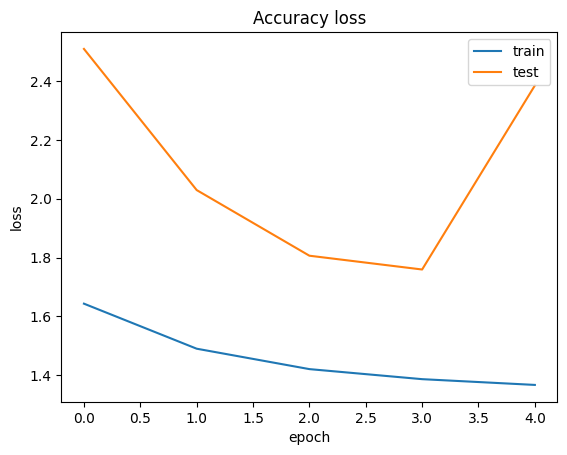

In [24]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv3_loss.png")

In [25]:
model.save("mobilenetCuDNNLSTMv3.h5")